In [1]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler




/home/kuba/miniconda3/envs/sym_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# root_path = "C:/Users/User/VisualStudio/t/SWLabs"
root_path = "."

dir = f"{root_path}/train_test_sw/train_sw/"
print(os.listdir(dir))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']


In [4]:
test_labels_path = f"{root_path}/train_test_sw/test_labels.json"
test_labels = pd.read_json(test_labels_path)
test_labels["path"] = test_labels.filename.map(
    lambda filename: f"{root_path}/train_test_sw/test_sw/{filename}"
)
test_labels

,filename,value,path
0,Beech1frame0000022.png,Beech,./train_test_sw/test_sw/Beech1frame0000022.png
1,Beech1frame0000026.png,Beech,./train_test_sw/test_sw/Beech1frame0000026.png
2,Beech1frame0000027.png,Beech,./train_test_sw/test_sw/Beech1frame0000027.png
3,Beech1frame0000044.png,Beech,./train_test_sw/test_sw/Beech1frame0000044.png
4,Beech1frame0000045.png,Beech,./train_test_sw/test_sw/Beech1frame0000045.png
...,...,...,...
254,Tomato5frame0000300.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000300.png
255,Tomato5frame0000309.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000309.png
256,Tomato5frame0000311.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000311.png
257,Tomato5frame0000313.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000313.png


In [5]:
train_dirs = os.listdir(f"{root_path}/train_test_sw/train_sw")

train_labels = pd.DataFrame()

for d in train_dirs:
    for f in os.listdir(f"{root_path}/train_test_sw/train_sw/{d}"):
        df_dict = pd.DataFrame(
            [
                {
                    "filename": f,
                    "path": f"{root_path}/train_test_sw/train_sw/{d}/{f}",
                    "value": d,
                }
            ]
        )
        # print(df_dict)
        train_labels = pd.concat([train_labels, df_dict], ignore_index=True)

train_labels

,filename,path,value
0,Beech1frame0000012.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
1,Beech1frame0000013.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
2,Beech1frame0000014.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
3,Beech1frame0000015.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
4,Beech1frame0000016.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
...,...,...,...
2870,Tomato5frameModifedModifed0000312.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2871,Tomato5frameModifedModifed0000315.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2872,Tomato5frameModifedModifed0000316.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2873,Tomato5frameModifedModifed0000317.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato


In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.img_labels = df["value"]
        self.img_dir = df["path"]
        self.transform = transform
        self.target_transform = target_transform
        self.labels_dict = {label: i for i, label in enumerate(df["value"].unique())}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image[:3], self.labels_dict[label]


In [8]:
# Batch size : How many images are used to calculate the gradient
batch_size = 32
number_of_classes = 5
# Train DataLoader
train_dataset = CustomImageDataset(
    train_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Validation DataLoader
validation_dataset = CustomImageDataset(
    test_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False
)

In [9]:
train_dataset[0][0], train_dataset[0][0].shape

(tensor([[[0.0627, 0.0745, 0.0824,  ..., 0.0745, 0.0667, 0.0510],
          [0.0667, 0.0784, 0.0863,  ..., 0.0588, 0.0510, 0.0549],
          [0.0824, 0.0902, 0.0941,  ..., 0.0510, 0.0549, 0.0588],
          ...,
          [0.0549, 0.0588, 0.0627,  ..., 0.0471, 0.0510, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0510],
          [0.0588, 0.0549, 0.0549,  ..., 0.0627, 0.0510, 0.0471]],
 
         [[0.0667, 0.0784, 0.0784,  ..., 0.0784, 0.0667, 0.0549],
          [0.0667, 0.0784, 0.0863,  ..., 0.0588, 0.0510, 0.0549],
          [0.0863, 0.0902, 0.0941,  ..., 0.0549, 0.0549, 0.0549],
          ...,
          [0.0588, 0.0627, 0.0667,  ..., 0.0471, 0.0510, 0.0549],
          [0.0588, 0.0549, 0.0549,  ..., 0.0549, 0.0588, 0.0510],
          [0.0627, 0.0588, 0.0588,  ..., 0.0627, 0.0510, 0.0431]],
 
         [[0.0471, 0.0549, 0.0588,  ..., 0.0549, 0.0471, 0.0392],
          [0.0471, 0.0588, 0.0627,  ..., 0.0392, 0.0353, 0.0392],
          [0.0588, 0.0667, 0.0667,  ...,

In [10]:
num_classes = 5
num_epochs = 100
batch_size = 32
learning_rate = 0.0009

model = AlexNet().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

# Train the model
total_step = len(train_loader)

In [11]:
costs = []
train_acc = []

In [12]:

total_step = len(train_loader)
for epoch in range(num_epochs):
    current_loss = 0    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
    costs.append(current_loss/90)
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    scheduler.step()
    # model.eval()   
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        train_acc.append(correct / total)
        print('Accuracy of the images: {} %'.format(100 * correct / total))

Epoch [1/100], Step [90/90], Loss: 1.5667
Accuracy of the images: 20.463320463320464 %
Epoch [2/100], Step [90/90], Loss: 1.7034
Accuracy of the images: 20.84942084942085 %
Epoch [3/100], Step [90/90], Loss: 1.6606
Accuracy of the images: 17.76061776061776 %
Epoch [4/100], Step [90/90], Loss: 1.6124
Accuracy of the images: 25.482625482625483 %
Epoch [5/100], Step [90/90], Loss: 1.5140
Accuracy of the images: 38.22393822393823 %
Epoch [6/100], Step [90/90], Loss: 1.6544
Accuracy of the images: 55.98455598455598 %
Epoch [7/100], Step [90/90], Loss: 1.2351
Accuracy of the images: 58.68725868725869 %
Epoch [8/100], Step [90/90], Loss: 1.1795
Accuracy of the images: 64.0926640926641 %
Epoch [9/100], Step [90/90], Loss: 1.1107
Accuracy of the images: 66.40926640926641 %
Epoch [10/100], Step [90/90], Loss: 1.1929
Accuracy of the images: 68.72586872586872 %
Epoch [11/100], Step [90/90], Loss: 1.5965
Accuracy of the images: 19.69111969111969 %
Epoch [12/100], Step [90/90], Loss: 1.5877
Accuracy

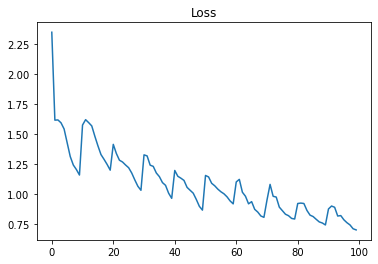

In [13]:
plt.plot(costs);
plt.title("Loss");

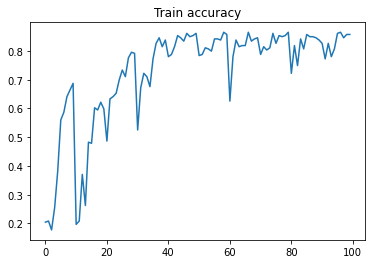

In [14]:
plt.plot(train_acc)
plt.title("Train accuracy");